# Initialize Libraries

In [566]:
var = None

In [567]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import pandas as pd

class adjmatrix:
    def __init__(self):
        # initialize a 1000x1000 matrix *mainly distance
        size = 10
        
        #edges
        self.matrix = np.zeros(shape=(size,size))
        self.edge_uv = np.array([[np.nan,np.nan,np.nan,np.nan]]) #np.empty(shape=[0, 4])
        
        #nodes
        self.nodedata = np.array([[0,0,0,0]]) # x,y,theta,z, includes features and poses (MEASURED)
        self.node = np.array([0]) # +1 for pose, -1 for landmarks, max is pose, min is landmarks
        
        self.converge = np.array([[]]) # store convergence
        self.weight = 0.5 
        self.cost = []
    
    def setweight (self,w):
        self.weight = w
        
    # U is the pose to pose measurements
    def posetopose(self, uX, uY, uO, uZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (pose) 
        node_type = max(self.node)+1  #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + u], axis = 0) #measured node = U + previous node

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_lastedge  #pose to newest node
        
    def poseloopclosure(self, uX, uY, uO, uZ, pose):
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (feature)
        #dont do anything

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        
        pose_index = np.where(self.node == pose)
        self.matrix[index_lastpose][pose_index] = index_lastedge  #pose to newest node
        
        
    def posetonewfeat(self, vX, vY, vO, vZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        node_type =  min(self.node)-1 #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + v], axis = 0) #measured node = U + previous node
        
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_newedge  #pose to newest node
        
    def posetooldfeat(self,vX, vY, vO, vZ, feat):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        #dont do anything
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1 #index of new edge
        
        feat_index = np.where(self.node == feat)
        
        self.matrix[index_lastpose][feat_index] = index_newedge  #pose to newest node

    
    def getcost(self, nodedata):
        x = np.where(self.matrix != 0)
        edges = np.asarray(x).T
        cost = 0
        for edge in edges:
            node_1 = nodedata[edge[1]] #node coordinates
            node_2 = nodedata[edge[0]] #node coordinates
            meas = self.edge_uv[int(self.matrix[edge[0]][edge[1]])]
            #print(node_1,node_2,meas)
            
            if self.node[edge[1]] > 0 and self.node[edge[0]] > 0 : #if pose to pose, dont count z
                #remove z values in error
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,0,error[3]])
                #error = np.array([error[0]*self.weight,error[1]*self.weight,error[2]*(1-self.weight),error[3]])
                errorsq = (error)**2
                errorsq = np.array([errorsq[0]*self.weight,errorsq[1]*self.weight,errorsq[2]*(1-self.weight),errorsq[3]])
                #print("p2p")
                
            else: #if pose to feat, dont count o
                #remove o values
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,error[2],error[3]])
                #error = np.array([error[0]*self.weight,error[1]*self.weight,error[2],error[3]])
                errorsq = (error)**2
                errorsq = np.array([errorsq[0]*self.weight,errorsq[1]*self.weight,errorsq[2],errorsq[3]])
                #print("p2f")
    
            cost = cost + np.linalg.norm(errorsq)
        #print ("cost",cost)
        return cost
        
    def getgradient(self,state):
        
        ind = []
        outd = []
        factor = []
        for i in range(len(self.node)):
            in_d = np.count_nonzero(self.matrix[:, i])
            out_d = np.count_nonzero(self.matrix[i, :])
            ind.append(in_d)
            outd.append(out_d)
            factor.append(-2*(out_d-in_d))
        print("in", ind)
        print("out", outd)
        print("factor", factor)
        print("\n")
        
        return factor
    
#     def getrotagradient(self,state):
        
#         factor = []
#         for i in range(len(self.node)):
#              if self.node > 0: #if pose
#                 #do something
#                 get x
#                 factor = 
            
#             out_d = np.count_nonzero(self.matrix[i, :])
#             ind.append(in_d)
#             outd.append(out_d)
#             factor.append(-2*(out_d-in_d))
#         print("in", ind)
#         print("out", outd)
#         print("factor", factor)
#         print("\n")
        
#         return factor
    
    
    def graph_posegraph(self,nodedata,i):
        
        if nodedata == []:
            nodedata = self.nodedata
        
        amat = self.matrix
        g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
        g.remove_nodes_from(list(nx.isolates(g)))
        
        #relabelling
        mapping = dict(zip(g, self.node))
        g = nx.relabel_nodes(g, mapping)
        
        #colourmap
        color_map = []
        for node in g.nodes:
            if node < 0:
                color_map.append('red')
            else: 
                color_map.append('white')      
                
        #layout
        layout = nx.spectral_layout(g)
        #layout = nx.spring_layout(g)
        
        #position
        position = copy.deepcopy(nodedata)
        ps = []
        for pos in position:
            ps.append(pos[:2])
        
        z = zip(self.node, ps)
        dic = dict(z)
        
        fig, ax = plt.subplots()
        
        nx.draw_networkx(g, pos=dic, node_color= color_map, with_labels = True)
        nx.draw_networkx_labels(g, pos=dic)
        plt.axis("on")
        #ax.set_xlim(-1, 8)
        #ax.set_ylim(-1,8)
        ax.set_xlim(0.5, -1)
        ax.set_ylim(0.5, -1)
        
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.savefig("pose/{}.jpg".format(i))
        plt.show()
        #print (amat)
        
        
    def gd(self, iterations, learning_rate, stopping_threshold, posegraph):
        
        currentstate = self.nodedata
        print("original")
        print(currentstate)
        
        factor = np.array(self.getgradient(currentstate))
        
        
        #copy to new
        newstate = copy.deepcopy(currentstate)
        previouscost = self.getcost(newstate)

        #learn
        for i in range(iterations):#
            
            if previouscost == 0: #perfect calculations
                break
            
            #print nodes update
            if (i % 1 == 0):
                print(i)
                print(newstate)
                if posegraph == True:
                    self.graph_posegraph(newstate,i)
            
            #get gradient
            gradient = copy.deepcopy(newstate)
            for i in range(gradient.shape[0]): #by nodes.
                
                if self.node[i] > 0: #pose node; remove all z
                    #gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],gradient[i][3]])
                    gradient[i] = gradient[i] - np.array([0,0,0,gradient[i][3]])
                else: #feat node; remove all o
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],0])
                    
                gradient[i] = gradient[i]*factor[i]
            #print("gradient\n",gradient)
            
            newstate = newstate + learning_rate*gradient #ONLY UPDATE THE NECCESSARY VARIABLES.
            currentcost = self.getcost(newstate)
            print ("curcost",currentcost)
            print()
            self.cost.append(currentcost)
            #print ("prvcost",previouscost)
            
            if currentcost > previouscost:
                break
            
            previouscost = currentcost 
        
        print("converge")
        print(newstate)
        self.converge = newstate
    
        
    def graph_location(self, nodedata):
        pose_ind, = np.where(self.node >= 0)
        land_ind, = np.where(self.node < 0)
        print (pose_ind,land_ind)
        #colour identity
    
    def pr(self):
        print ("node (pose/landmark)\n",self.node)
        print ("nodedata (assumed state)\n",self.nodedata)
        print ("edgedata (u/v)\n",self.edge_uv)
        print ("\n")
        print (np.matrix(self.matrix))
        print ()
    
    def prcost(self):
        ite = list(range(0, len(self.cost)))
        cs = self.cost
        plt.plot(ite,cs)
        plt.title('Cost vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.show()
        print (self.cost [-1])
    
    def prcost_n(self):
        return(self.cost [-1])
    def prcost_i(self):
        return(len(self.cost))
         

# Intializing Matrix, 
Measured Data (from excel)
Compare with Ground Truth

In [568]:
#df = pd.read_csv("dataset/e3v2.csv")
#df = pd.read_csv("dataset/e3v4xyswap.csv")
pdf = pd.read_csv("dataset/e3v4initialcoordsswap.csv")
df = pdf[0:10]
#df = pdf
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


In [569]:
a = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

# Visualize Gradient Descent

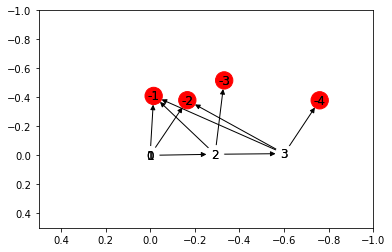

In [570]:
a.graph_posegraph([],0)

In [571]:
#a.nodedata[np.where(a.node>0)

# Visualize Gradient Descent

In [572]:
import os
import glob

#Clear 
files = glob.glob('pose/*')
for f in files:
    os.remove(f)

In [573]:
a.gd(iterations = 100, learning_rate = 0.001, stopping_threshold = 0.1, posegraph = False) #Remember to Change

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 1, 3, 2, 1, 1, 1, 1]
out [1, 3, 0, 0, 3, 0, 3, 0]
factor [-2, -4, 6, 4, -4, 2, -4, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.1

In [574]:
from os import listdir
from os.path import isfile, join
mypath = "pose"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("number of jpg: "+str(len(onlyfiles)))

number of jpg: 0


In [575]:
import imageio

with imageio.get_writer('optimization.gif', mode='I') as writer:
    for filename in list(range(0,len(onlyfiles))):
        image = imageio.imread("pose/"+str(filename)+".jpg")
        writer.append_data(image)
        
print("saved")

saved


# Convergence of Gradient Descent

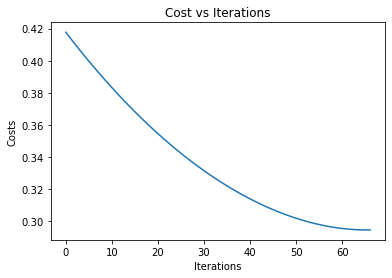

0.29443091951105754


<Figure size 432x288 with 0 Axes>

In [576]:
a.prcost()
plt.savefig("GradDescent.jpg")

# Comparison of Accuracy

Optimized Estimate vs Initial vs Ground Truth

In [577]:
initial = a.nodedata[np.where(a.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
initialxy = []
#initialdiff = []
initialrote = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:3].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    initialrote.append(rot.round(decimals = 3) )
    #initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
optim = a.converge[np.where(a.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
optimxy = []
#optimdiff = []
optimrote = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:3].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i][0:2]
    rot = abs(optim[i][2]-groundtruth[i][2])
    optimrote.append(rot.round(decimals = 3) )
    #optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
compare = pd.DataFrame(list(zip(groundtruth, initialxy, initialrote, initialL2, optimxy, optimrote, optimL2)), columns = ('groundtruth', 'initialxy', 'initialrotE', 'initialL2', 'optimxy', 'optimrotE', 'optimL2'))

compare.to_csv("comparisonNORMAL.csv")
compare

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.222, -0.006, 0.172]",0.172,0.023
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.459, -0.009, 0.248]",0.248,0.060


# To Do List
1) set up controlled experiment for camera, manually extract following data (pose to pose movement, pose to frame movements, 

1) Experimental Data.
2) Offline Algorithm

*mention that initial pose tagged to global frame.
*why cost function?

In [578]:
#a.nodedata[np.where(a.node>0)]

# Testing Parameters (Learning Rate)

In [579]:
pdf = pd.read_csv("dataset/e3v4initialcoordsswap.csv")
df = pdf[0:10]


In [580]:
h = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        h.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            h.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            h.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

In [581]:
#Track Costs
LR = []
Costs = []
Ite = []

In [582]:
%%capture
learning = 0.0001
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [583]:
%%capture
learning = 0.0002
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [584]:
%%capture
learning = 0.0004
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [585]:
%%capture
learning = 0.0008
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [586]:
%%capture
learning = 0.0012
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [587]:
%%capture
learning = 0.0024
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [588]:
%%capture
learning = 0.0048
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [589]:
%%capture
learning = 0.0096
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [590]:
%%capture
learning = 0.0192
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [682]:
lrdf = pd.DataFrame(list(zip(LR, Costs,Ite)), 
             columns = ('Learning Rate', 'Final Cost', 'Iterations'))

s1 = pd.Series(100)
s2 = s1.append(abs(lrdf.Iterations.diff(periods=-1)).drop([8]), ignore_index = True)
lrdf["Iterations"] = s2

lrdf.to_csv("learningrate.csv")
lrdf

,Learning Rate,Final Cost,Iterations
0,0.0001,0.386395,100.0
1,0.0002,0.357103,100.0
2,0.0004,0.315328,100.0
3,0.0008,0.294508,84.0
4,0.0012,0.294380,56.0
5,0.0024,0.294341,29.0
6,0.0048,0.294234,15.0
7,0.0096,0.295004,8.0
8,0.0192,0.318774,5.0


,Learning Rate,Final Cost,Iterations
0,0.0001,0.386395,100.0
1,0.0002,0.357103,100.0
2,0.0004,0.315328,100.0
3,0.0008,0.294508,84.0
4,0.0012,0.294380,56.0
5,0.0024,0.294341,29.0
6,0.0048,0.294234,15.0
7,0.0096,0.295004,8.0
8,0.0192,0.318774,5.0


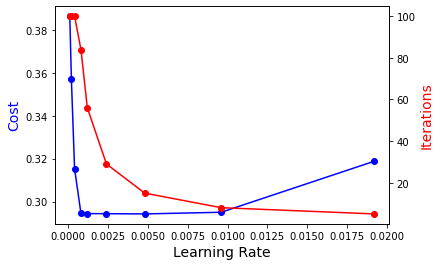

In [686]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(lrdf['Learning Rate'], lrdf['Final Cost'], color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Learning Rate",fontsize=14)
# set y-axis label
ax.set_ylabel("Cost",color="blue",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(lrdf['Learning Rate'], lrdf["Iterations"],color="red",marker="o")
ax2.set_ylabel("Iterations",color="red",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('Cost vs Learning Rate.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')



# Testing Parameters (Learning Rate and Weighting)

In [593]:
j = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        j.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            j.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            j.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

In [594]:
#Track Costs
Ratio = []
Trans = []
Rota = []
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
learning = 0.001

k = [0.35,0.30,0.25,0.20,0.15,0.10,0.05,0.01,0.001,0.005,0.001,0.0005,0.0001]

In [595]:
%%capture

R = k[0]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [596]:
%%capture

R = k[1]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [597]:
%%capture

R = k[2]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff) 
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [598]:
%%capture

R = k[3]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [599]:
%%capture

R = k[4]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff) 
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [600]:
%%capture

R = k[5]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [601]:
%%capture

R = k[6]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [602]:
%%capture

R = k[7]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [603]:
%%capture

R = k[8]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [604]:
%%capture

R = k[9]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [605]:
%%capture

R = k[10]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [606]:
%%capture

R = k[11]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [607]:
%%capture

R = k[12]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [608]:
%%capture

R = k[13]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

IndexError: list index out of range

In [609]:
%%capture

R = k[14]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(loop.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

IndexError: list index out of range

In [610]:
er = pd.DataFrame(list(zip(Ratio,Trans,Rota)), 
             columns = ('Weighting Ratio', 'Translational Error', 'Rotational Error'))

er.to_csv("WeightingRatio.csv")
er

,Weighting Ratio,Translational Error,Rotational Error
0,0.3500,0.083168,0.420
1,0.3000,0.083168,0.420
2,0.2500,0.085871,0.422
3,0.2000,0.085871,0.422
4,0.1500,0.088588,0.423
5,0.1000,0.094059,0.427
6,0.0500,0.110779,0.437
7,0.0100,0.194739,0.489
8,0.0010,0.274797,0.539
9,0.0050,0.233795,0.513


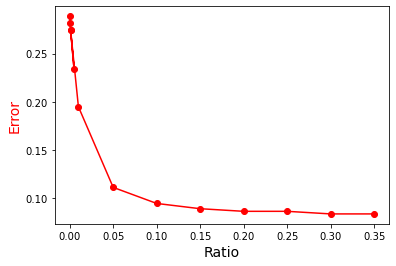

In [611]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(er['Weighting Ratio'], er['Translational Error'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Ratio",fontsize=14)
# set y-axis label
ax.set_ylabel("Error",color="red",fontsize=14)


plt.savefig("Error vs Ratio.jpg")

# Comparisons

GT vs Intial vs Optimal

C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


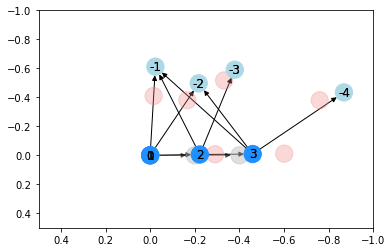

In [612]:

#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal vs GT.jpg")

Intial vs Optimal

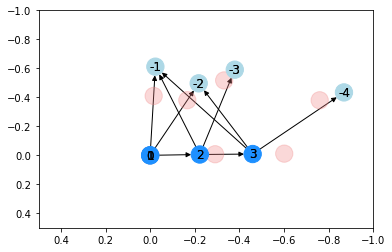

In [613]:
#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal.jpg")

# Test Loop Closure

In [614]:
#df = df[0:10]
df = pdf
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


In [615]:
loop = adjmatrix() 
for i in range(11):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        loop.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            loop.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            loop.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
            
e = df.iloc[11]
loop.poseloopclosure(e.x,e.y,e.o,e.z, 1)
e = df.iloc[12]
loop.posetooldfeat(e.x,e.y,e.o,e.z,-2)

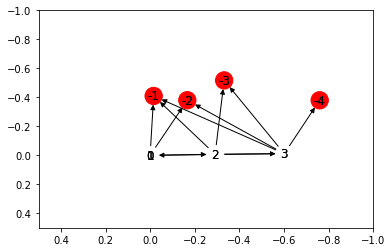

In [616]:
loop.graph_posegraph([],0)

In [617]:
loop.gd(iterations = 1000, learning_rate = 0.001, stopping_threshold = 0.1, posegraph = False) #Remember to Change

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 2, 3, 2, 1, 2, 1, 1]
out [1, 3, 0, 0, 3, 0, 5, 0]
factor [-2, -2, 6, 4, -4, 4, -8, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.1

In [618]:
initial = loop.nodedata[np.where(loop.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
initialxy = []
#initialdiff = []
initialrote = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:3].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    initialrote.append(rot.round(decimals = 3) )
    #initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
optim = loop.converge[np.where(loop.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
optimxy = []
#optimdiff = []
optimrote = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:3].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i][0:2]
    rot = abs(optim[i][2]-groundtruth[i][2])
    optimrote.append(rot.round(decimals = 3) )
    #optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
compare_lc = pd.DataFrame(list(zip(groundtruth, initialxy, initialrote, initialL2, optimxy, optimrote, optimL2)), columns = ('groundtruth', 'initialxy', 'initialrotE', 'initialL2', 'optimxy', 'optimrotE', 'optimL2'))

compare_lc.to_csv("comparisonLOOPCL.csv")
compare_lc

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.245, -0.006, 0.189]",0.189,0.045
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.425, -0.008, 0.23]",0.230,0.027


ABOVE (WITH LOOP CLOSURE)

BELOW (WITHOUT LOOP CLOSURE)

In [619]:
compare

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.222, -0.006, 0.172]",0.172,0.023
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.459, -0.009, 0.248]",0.248,0.060


C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


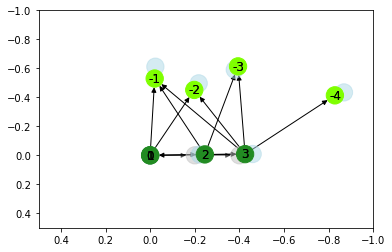

In [620]:
#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal without Loop Closure
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('lightblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Optimal with Loop Closure
nodedata = loop.converge

amat = loop.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, loop.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('chartreuse')
    else: 
        color_map.append('forestgreen')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(loop.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("LoopClosure vs NonLoopClosure.jpg")